In [1]:
import Pkg; Pkg.add("Yao")

    Updating registry at `C:\Users\Aida\.julia\registries\General`
    Updating git-repo `https://github.com/JuliaRegistries/General.git`
   Resolving package versions...
  No Changes to `C:\Users\Aida\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\Aida\.julia\environments\v1.6\Manifest.toml`


In [2]:
import Pkg; Pkg.add("BitBasis")

   Resolving package versions...
  No Changes to `C:\Users\Aida\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\Aida\.julia\environments\v1.6\Manifest.toml`


In [3]:
import Pkg; Pkg.add("LightGraphs")

   Resolving package versions...
  No Changes to `C:\Users\Aida\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\Aida\.julia\environments\v1.6\Manifest.toml`


In [4]:
import Pkg; Pkg.add("GraphPlot")

   Resolving package versions...
  No Changes to `C:\Users\Aida\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\Aida\.julia\environments\v1.6\Manifest.toml`


In [5]:
import Pkg; Pkg.add("Plots")

   Resolving package versions...
  No Changes to `C:\Users\Aida\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\Aida\.julia\environments\v1.6\Manifest.toml`


In [6]:
import Pkg; Pkg.add("CSV")

   Resolving package versions...
  No Changes to `C:\Users\Aida\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\Aida\.julia\environments\v1.6\Manifest.toml`


In [7]:
import Pkg; Pkg.add("DataFrames")

   Resolving package versions...
  No Changes to `C:\Users\Aida\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\Aida\.julia\environments\v1.6\Manifest.toml`


In [8]:
import Pkg; Pkg.add("StatsBase")

   Resolving package versions...
  No Changes to `C:\Users\Aida\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\Aida\.julia\environments\v1.6\Manifest.toml`


In [9]:
using Yao
using Yao.ConstGate
using BitBasis
using Plots
using GraphPlot
using LightGraphs
using DataFrames
using CSV
using StatsBase
using LsqFit

LoadError: ArgumentError: Package LsqFit not found in current path:
- Run `import Pkg; Pkg.add("LsqFit")` to install the LsqFit package.


In [10]:
const u = 1.35
const Ω_max = 1.89
const δ_0 = -2.0
const δ_max = 1.0

1.0

In [11]:
function get_edges(graph::Vector{NTuple{2, Float64}})
    Nv = size(graph)[1]
    edges = falses(Nv, Nv)
    for i in 1:(Nv-1)
        xi, yi = graph[i]
        for j in (i+1):Nv
            xj, yj = graph[j]

            dij = sqrt((xi - xj)^2. + (yi - yj)^2.)
            if dij <= 1.0
                edges[i,j] = true
            end
        end
    end
    return findall(edges)
end

function Ω(t::Float64)
    if 0 <= t <= 0.25
        return 4. * Ω_max * t
    elseif 0.25 < t <= 0.69
        return Ω_max
    elseif 0.69 < t <= 1
        return -Ω_max * t / 0.31 + 1.89/0.31
    end
end

function δ(t::Float64)
    if 0 <= t <= 0.25
        return δ_0
    elseif 0.25 < t <= 0.69
        return t * (δ_0 + δ_max)/0.44 + δ_0
    elseif 0.69 < t <= 1
        return δ_max
    end
end 

function hamiltonian(graph::Vector{NTuple{2, Float64}}, edges::Vector{CartesianIndex{2}}, t::Float64)
    # the UD-MIS Hamiltonian
    Nv = size(graph)[1] # number of vertices

    interaction_term = map(1:size(edges)[1]) do i
        l,m = edges[i][1], edges[i][2]
        repeat(Nv,u*P1,(l,m))
    end |> sum
    interaction_term - δ(t)*sum(map(i->put(Nv,i=>P1), 1:Nv)) + Ω(t)*sum(map(i->put(Nv,i=>X), 1:Nv))
end

function run_annealing(graph::Vector{NTuple{2, Float64}}, edges::Vector{CartesianIndex{2}}, dt::Float64)
    psi_t = zero_state(size(graph)[1])
    for t in 0:dt:1.0
        h = hamiltonian(graph, edges, t)
        psi_t = psi_t |> TimeEvolution(h, dt)
    end
    return psi_t
end


run_annealing (generic function with 1 method)

In [12]:
graph = [(0.3461717838632017, 1.4984640297338632), (0.6316400411846113, 2.5754677320579895), (1.3906262250927481, 2.164978861396621), (0.66436005100802, 0.6717919819739032), (0.8663329771713457, 3.3876341010035995), (1.1643107343501296, 1.0823066243402013)]
edges = get_edges(graph)
dt = 0.001

0.001

In [86]:
#psi = run_annealing(graph, edges, dt)
#samples = measure(psi; nshots=10)
#@show samples

ArrayReg{1, ComplexF64, Array...}
    active qubits: 6/6

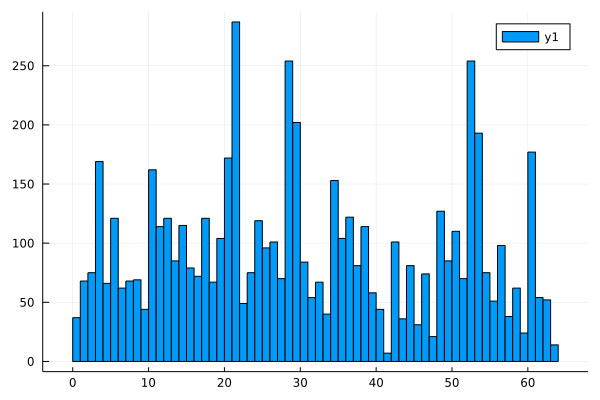

In [120]:
nshots=6000
psi = run_annealing(graph, edges, dt)
samples = measure(psi; nshots)

d=Vector{Float64}()
for i in 1:nshots
    r=packbits(bitarray(samples[i], 6))
    append!(d,r)
end
histogram(d,bins=floor(Int8,findmax(d)[1]))

In [121]:
hist=fit(Histogram,d,nbins=floor(Int8,findmax(d)[1]))
sol=bitarray(argmax(hist.weights),6)
solCSV=DataFrame([sol],:auto)
CSV.write("qUDMIS.csv",solCSV)

"qUDMIS.csv"